# Nested Sampling on simulated JWST Neptune data 

In [1]:
from archnemesis import *

Let's load in an example Neptune setup. 

In [2]:
runname = 'neptune'

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = read_input_files(runname)

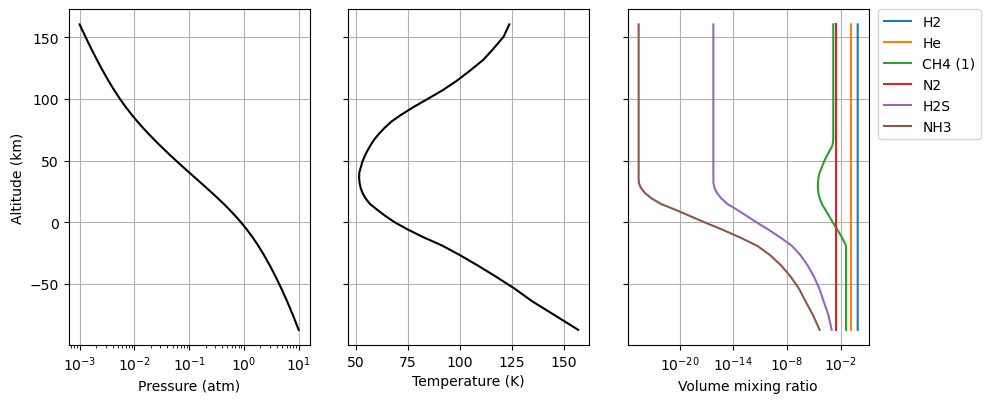

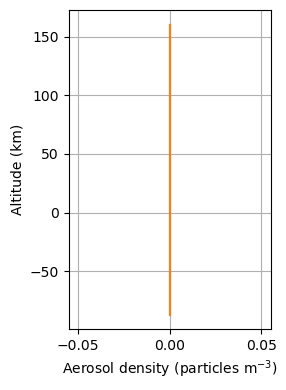

In [3]:
Atmosphere.plot_Atm()
Atmosphere.plot_Dust()

Atmosphere.DUST_UNITS_FLAG = [-1]*Atmosphere.DUST.shape[1]


We'll generate a spectrum, add some noise to it, and save it to our spx file. We're only using a small region of the spectrum for speed.

In [4]:
%%time
ForwardModel = ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV = ForwardModel.nemesisfm()

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0024492587068203
Maximum integral of phase function is  1.0029856636186842
CIRSrad :: Aerosol optical depths at  1.8490000175515888  ::  [0.37875526 0.        ]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  6 ; NMU =  5 ; NPHI =  100
CPU times: user 18 s, sys: 483 ms, total: 18.5 s
Wall time: 18.4 s


In [5]:
new_spectrum = SPECONV * np.random.normal(1,0.02,SPECONV.shape)
new_spectrum_error = new_spectrum*0.02

def write_to_spx(filename, array, column):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    j = 0
    for i, line in enumerate(lines):
        columns = line.split()
        if len(columns) == 3:
            columns[column] = f"{float(array[j]):.5e}"  # Replacing the column with new array values
            j += 1
            lines[i] = ' '.join(columns) + '\n'
                
    with open(filename, 'w') as file:
        file.writelines(lines)

        
#Not actually saving, so saved nested sampling results are still valid
# write_to_spx(runname+'.spx',new_spectrum,1)
# write_to_spx(runname+'.spx',new_spectrum_error,2)

        

Now, let's reload, with our new slightly noisy spectrum. We're keeping the apr file the same. This means that if we were running optimal estimation, we would start at the optimal point and the retrieval would end quickly. However, because nested sampling draws randomly from the prior distribution, it will still fully explore the space defined in the apr file.

In [6]:
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = read_input_files(runname)

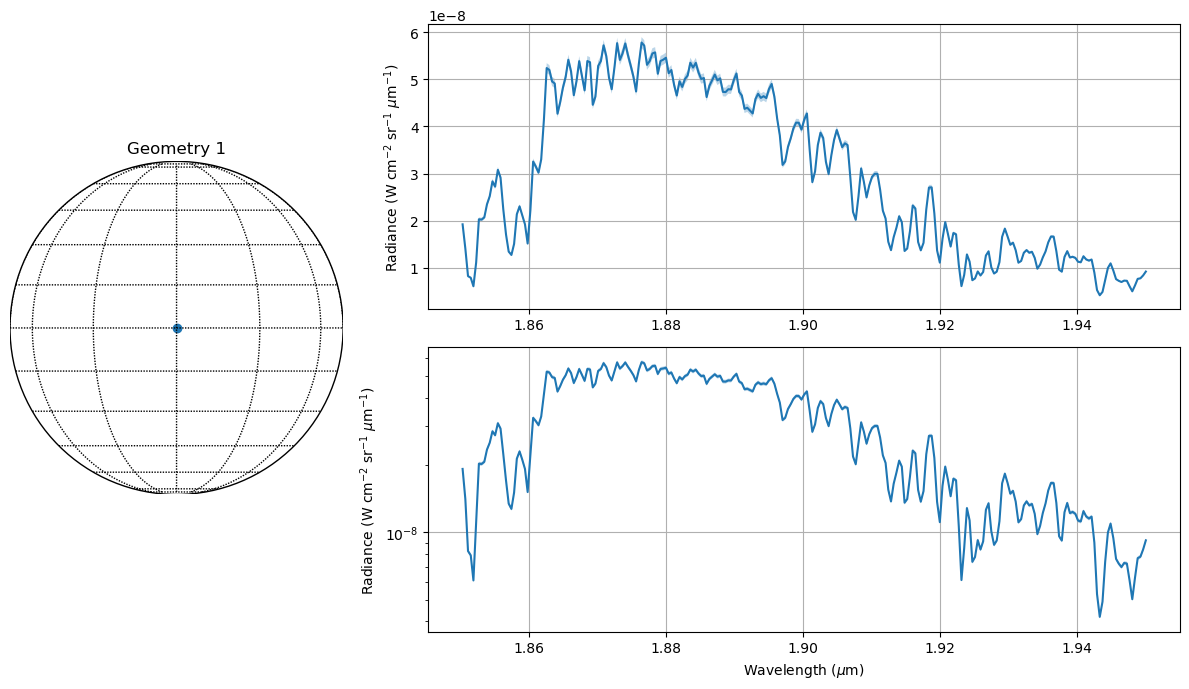

In [7]:
Measurement.plot_nadir()

Now let's run our nested sampling. This would usually take a long time (~40 minutes for me), but this example folder already contains the results from a previous run, so we can just investigate the output.

In [8]:
import subprocess

legacy_files=True  
retrieval_method=1  #Nested Sampling
NCores=30        

subprocess.run(["mpiexec", "-np", str(NCores), "python", "-c", 
                f"import archnemesis as ans; ans.Retrievals.retrieval_nemesis('{runname}', legacy_files={legacy_files}, retrieval_method={retrieval_method}, NCores={NCores})"])



 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.551503
Replacements:                               3962
Total Samples:                              7184
Nested Sampling ln(Z):               -120.555518
Importance Nested Sampling ln(Z):    -120.484335 +/-  0.082397
 ln(ev)=  -120.27154263399109      +/-  0.12767535106337663     
 Total Likelihood Evaluations:         7184
 Sampling finished. Exiting MultiNest
  analysing data from chains/.txt
  analysing data from chains/.txt
Creating marginal plot ...
Model run OK
 Elapsed time (s) = 2.4544949531555176
  analysing data from chains/.txt
  analysing data from chains/.txt
Creating marginal plot ...
Model run OK
 Elapsed time (s) = 2.5625524520874023
  analysing data f

CompletedProcess(args=['mpiexec', '-np', '30', 'python', '-c', "import archnemesis as ans; ans.Retrievals.retrieval_nemesis('neptune', legacy_files=True, retrieval_method=1, NCores=30)"], returncode=0)

Let's also do an optimal estimation run and compare. This should be quick.

In [9]:
legacy_files=True    
retrieval_method=0  
NCores=4
ans.Retrievals.retrieval_nemesis(runname,legacy_files=legacy_files,retrieval_method=retrieval_method,NCores=NCores)

nemesis :: Calculating Jacobian matrix KK
Calculating numerical part of the Jacobian :: running 4 forward models 
Calculating forward model 1/4
Calculating forward model 2/4
Calculating forward model 3/4
Calculating forward model 4/4
Calculated forward model 4/4
Calculated forward model 3/4
Calculated forward model 2/4
Calculated forward model 1/4
nemesis :: Calculating gain matrix
nemesis :: Calculating cost function
calc_phiret: phi1, phi2 = 235.14976992457446, 0.0)
chisq/ny = 0.9294457309271718
Assess:
Average of diagonal elements of Kk*Sx*Kt : 9.622978821599678e-18
Average of diagonal elements of Se : 4.686677258343464e-19
Ratio = 20.532625335931456
Average of Kk*Sx*Kt/Se element ratio : 26.06191686469022
******************* ASSESS WARNING *****************
Insufficient constraint. Solution likely to be exact
****************************************************
nemesis :: Iteration 0/10
nemesis :: Calculating next iterated state vector
Normalisation of phase function should be 1.0


Let's compare these two results.

In [10]:
lat,lon,ngeom,ny,wave,specret,specmeas,specerrmeas,nx,Var,aprprof,aprerr,retprof,reterr = ans.Files.read_mre('neptune')

In [11]:
NestedSampling = coreretNS(runname,Variables,Measurement,Atmosphere,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer)



 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.551503
Replacements:                               3962
Total Samples:                              7184
Nested Sampling ln(Z):               -120.555518
Importance Nested Sampling ln(Z):    -120.484335 +/-  0.082397
  analysing data from chains/.txt
 ln(ev)=  -120.27154263399109      +/-  0.12767535106337663     
 Total Likelihood Evaluations:         7184
 Sampling finished. Exiting MultiNest

Evidence: -120.3 +- 0.1

Parameter values:
              0 : -0.908 +- 0.018
              1 : -1.897 +- 0.009
              2 : 0.194 +- 0.035


  analysing data from chains/.txt


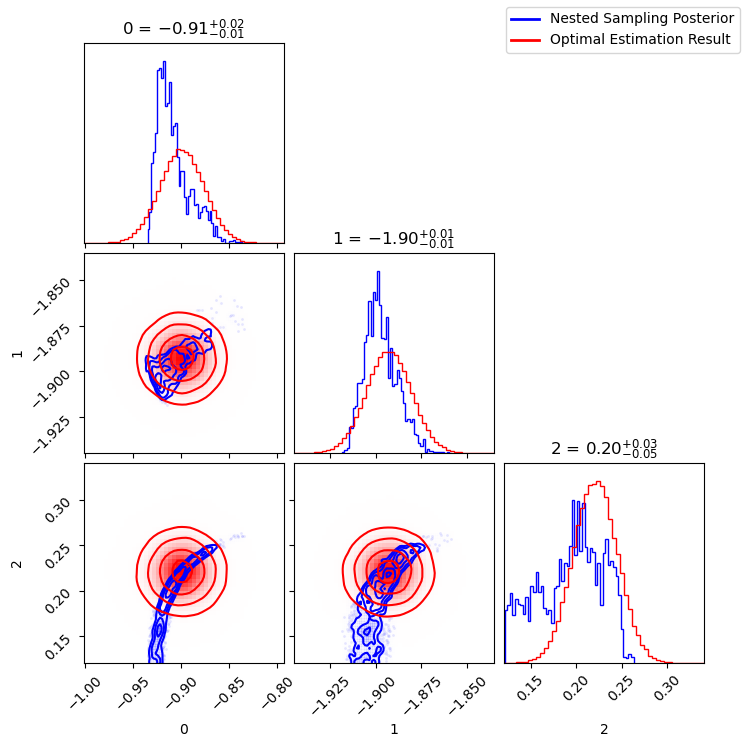

In [12]:
NestedSampling.compare()

We can see that both methods converge to the same value (within error). However, the nested sampling clearly shows that we cannot constrain variable 2 (the fractional scale height of the cloud) as much as optimal estimation would lead us to believe.